# Helmholtz 1D Multilevel Development: Repetitive + Alignment
* Constant $k$.
* Discretization: 5-point (4th order).
* Fixed-domain problem; non-repetitive, so we generate TVs over entire domain.
* Fix aggregate size $a$ and $n_c$ (# principal components) over entire domain. Overlap the last two aggregates if needed.
* Optimize $a, n_c$ to maximize the mock cycle predicted error reduction efficiency.

In [1]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

In [2]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96
# Scaled wave number.
kh = 0.7

repetitive = True

# Number of test vectors.
num_examples = 3
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

## Shrinkage Factor
Given an iterative method, we can calculate whether it's a good smoothing candidate using the **shrinkage factor** $\mu$, even before measuring its mock cycle rate (which measures the combination of the smoother andcoarsening operator $R$).

* Start from $5$ different random starts $x_0 = rand[-1,1]$, for each  apply the method for $A x = 0$ to obtain iterates $x_1, x_2, \dots$.
* For each iterate, calculate residual norm $r_i := \|A x_i\|_2$ and reduction per sweep, $\mu_i := (r_i / r_0)^{\frac{1}{i}}$, $i = 1, 2, \dots$.
* Average $\mu_i$ over the $5$ starts.
* Terminate the method at $j = i + 3$, where $i = argmin_i \mu_i$ and set $\mu \leftarrow \mu_j$.

## Level 0->1 Coarsening

### Relaxation Shrinkage Factor

PODR = point of diminishing returns
Efficiency = residual reduction per sweep
kh 0
INFO     Iter     |r|                         |x|         RER
INFO     0     1.406e+00                    4.468e-01    3.139
INFO     1     7.628e-01 (0.544) [0.544]    3.342e-01    2.288 (0.728)
INFO     2     4.353e-01 (0.572) [0.558]    2.811e-01    1.561 (0.682)
INFO     3     2.723e-01 (0.627) [0.580]    2.539e-01    1.086 (0.695)
INFO     4     1.864e-01 (0.686) [0.606]    2.380e-01    0.795 (0.732)
INFO     5     1.391e-01 (0.746) [0.632]    2.276e-01    0.622 (0.782)
INFO     6     1.117e-01 (0.803) [0.658]    2.201e-01    0.516 (0.831)
INFO     7     9.389e-02 (0.840) [0.681]    2.144e-01    0.444 (0.863)
INFO     8     8.141e-02 (0.867) [0.702]    2.099e-01    0.393 (0.886)
INFO     9     7.202e-02 (0.884) [0.720]    2.062e-01    0.353 (0.900)
INFO     10    6.475e-02 (0.898) [0.737]    2.030e-01    0.322 (0.912)
INFO     [1.    0.544 0.558 0.58  0.606 0.632 0.658 0.681 0.702 0.72  0.737]
Kac  

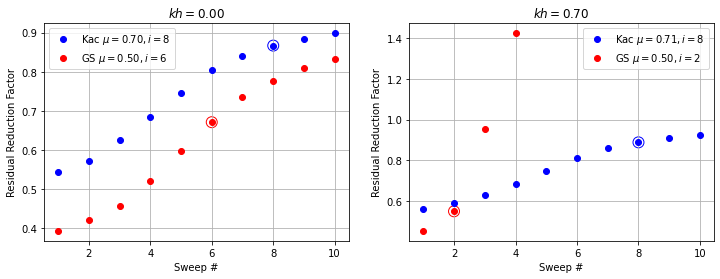

In [16]:
kh_values = [0, kh]
fig, axs = plt.subplots(1, len(kh_values), figsize=(12, 4))

kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

print("PODR = point of diminishing returns")
print("Efficiency = residual reduction per sweep")
# Kaczmarz.
for kh_value, ax in zip(kh_values, axs):
    print("kh", kh_value)
    a_kh = hm.linalg.helmholtz_1d_5_point_operator(kh_value, n).tocsr()
    operator = lambda x: a_kh.dot(x)

    for title, relax, color in zip(("Kac", "GS"), (kaczmarz, gs), ("blue", "red")):
        method = relax(a_kh)
        factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
            operator, lambda x, b: method.step(x, b), (a_kh.shape[0], ), 
            print_frequency=1, max_sweeps=10, slow_conv_factor=1.1, leeway_factor=leeway_factor)
        hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
        print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
            title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))
    
    ax.set_title(r"$kh = {:.2f}$".format(kh_value))
    ax.legend()

The point of diminishing returns in each scatterplot is circled.

This estimate seems to give a reasonable estimate for both $kh$ values and both relaxation schemes (albeit not a quantitative smoothing factor, which can only be defined based on a coarsening), showing that GS is a better smoother for both $kh = 0, 0.5$, but slightly diverges for $kh = 0.5$. The RER at the point of diminishing returns is much smaller.

Averaging over multiple random starts helps reduce noise, as well as assuming a constant reduction per sweep in the initial sweeps (as opposed to a linear model, say). We are only interested in a rough estimate.

**TODO: output asymptotic convergence factor a little past PODR to see if relax diverges.**

### Coarsening: Optimizing $a$, $n_c$

In [17]:
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
a0 = a
level = hm.setup.hierarchy.create_finest_level(a)

In [18]:
_LOGGER.info("kh {}".format(kh))
x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel.create(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))

factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    operator, lambda x, b: level.relax(x, b), (a_kh.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log.append(x)

_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

INFO     kh 0.7
INFO     Relax at level 0 size 96
INFO     [1.    0.558 0.579 0.599 0.622 0.647 0.671 0.694 0.714 0.733 0.75  0.764 0.778 0.789 0.8   0.809 0.818 0.826 0.833 0.839 0.845]
INFO     Relax conv 0.93 shrinkage 0.65 PODR RER 0.59 after 5 sweeps. Work 1.0 eff 0.65
INFO     Generating TVs with 5 sweeps
INFO     RER 0.634


In [19]:
# Calculate mock cycle predicted efficiency.
aggregate_size_values = np.array([2, 4, 6])
nu_values = np.arange(1, 5, dtype=int)
# TODO: determine this based on cycle index.
max_conv_factor = 0.3

coarsener = hm.setup.coarsening_uniform.UniformCoarsener(level, x, aggregate_size_values, nu_values, repetitive=repetitive)
r, aggregate_size, nc, cr, mean_energy_error, nu, mock_conv, mock_work, mock_efficiency = \
    coarsener.get_optimal_coarsening(max_conv_factor)
print("kh {:.2f} R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle nu {} conv {:.2f} efficiency {:.2f}".format(
  kh, r.shape, aggregate_size, nc, cr, mean_energy_error, nu, mock_conv, mock_efficiency))

kh 0.70 R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.2717; mock cycle nu 2 conv 0.29 efficiency 0.74


In [20]:
info = coarsener.get_coarsening_info(1)
columns=("i", "a", "nc", "cr", "Energy Error", "nu", "conv", "work", "eff")
pd.DataFrame(info).rename(columns=dict(enumerate(columns))).astype(
    {"i": "int32", "a": "int32", "nc": "int32", "nu": "int32"})

,i,a,nc,cr,Energy Error,nu,conv,work,eff
0,0,2,1,0.50,0.47,1,0.64,2.00,0.80
1,0,2,1,0.50,0.47,2,0.35,4.00,0.77
2,0,2,1,0.50,0.47,3,0.24,6.00,0.79
3,0,2,1,0.50,0.47,4,0.26,8.00,0.85
4,1,4,1,0.25,0.61,1,0.86,1.33,0.89
5,1,4,1,0.25,0.61,2,0.86,2.67,0.94
6,1,4,1,0.25,0.61,3,0.89,4.00,0.97
7,1,4,1,0.25,0.61,4,0.83,5.33,0.96
8,2,4,2,0.50,0.27,1,0.63,2.00,0.80
9,2,4,2,0.50,0.27,2,0.29,4.00,0.74


The optimal coarsening (based on mock cycle efficiency) is for a larger aggregate ($4/2$) only for a sufficiently large $kh$, of $\approx 0.7$. Even at $kh = 0.5$, $2/1$ coarsening is (very slightly) better.

### Build Coarse Level: Two-level Bootstrap Cycle

In [22]:
max_levels = 2
num_bootstrap_steps = 1

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, neighborhood=neighborhood, repetitive=repetitive)
    x_log.append(x)
    r_log.append(multilevel[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.970 asymptotic RQ -0.027 RER 0.040 P error 0.016
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.0540; mock cycle nu 2 conv 0.32 eff 0.75
INFO     Mock cycle conv factor [0.329 0.188 0.12 ]
INFO     P max error: fit 0.028 val 0.016 test 0.041; alpha mean 0.000
INFO     all  set size 3  P L2 error mean 0.02 max 0.03 A error mean 0.04 max 0.06
INFO     Level 1 size 48
INFO     RER 0.061048
INFO     --------------------------------------------------------------------------------


<!-- ### Interpolation Error -->

In [23]:
# p = multilevel[1].p
# r = multilevel[1].r
# x_fit, x_test = x[:, :-num_test_examples], x[:, -num_test_examples:]
# e = x - p.dot(r.dot(x))
# error = norm(e, axis=0) / norm(x, axis=0)
# error_a = norm(level.a.dot(e), axis=0) / norm(x, axis=0)
# print(error_a)
# # print(e[2])
# # print(p[2].todense())
# # print(x[2])

### Level 1 Relaxation Shrinkage Factor

INFO     Iter     |r|                         |x|         RER
INFO     0     2.553e-01                    4.446e-01    0.577
INFO     1     1.039e-01 (0.405) [0.405]    2.921e-01    0.353 (0.616)
INFO     2     5.359e-02 (0.529) [0.460]    2.293e-01    0.237 (0.676)
INFO     3     3.574e-02 (0.667) [0.522]    2.041e-01    0.178 (0.753)
INFO     4     2.674e-02 (0.749) [0.571]    1.895e-01    0.144 (0.810)
INFO     5     2.143e-02 (0.802) [0.612]    1.798e-01    0.123 (0.848)
INFO     6     1.810e-02 (0.845) [0.646]    1.727e-01    0.109 (0.882)
INFO     7     1.588e-02 (0.878) [0.675]    1.672e-01    0.099 (0.909)
INFO     8     1.431e-02 (0.901) [0.700]    1.626e-01    0.092 (0.929)
INFO     9     1.314e-02 (0.918) [0.721]    1.586e-01    0.086 (0.943)
INFO     10    1.222e-02 (0.930) [0.740]    1.551e-01    0.082 (0.953)
INFO     [1.    0.405 0.46  0.522 0.571 0.612 0.646 0.675 0.7   0.721 0.74 ]
kac   conv 0.93 shrinkage 0.52 PODR RER 0.18 after  3 sweeps. Work  1 efficiency 0.52


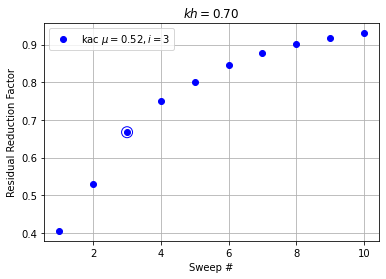

In [24]:
level = multilevel[1]
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=10, slow_conv_factor=2, 
    num_examples=5, leeway_factor=leeway_factor)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

The coarse-level relaxation is still a good smoother, even though less effective than the fine-level relaxation. This means we built reasonable coarse-level equations that can be solved without advanced relaxation design techniques.

### Relaxation Cycle Shrinkage
We compare a two-level relaxation cycle with $\nu_1=1, \nu_2=1, \nu_{coarse}=$ # relaxations until the coarse-level relaxation slows down, with fine-level Kaczmarz relaxation.

INFO     Iter     |r|                         |x|         RER
INFO     0     1.251e+00                    4.469e-01    2.803
INFO     1     6.966e-01 (0.557) [0.557]    3.461e-01    2.022 (0.720)
INFO     2     4.105e-01 (0.590) [0.573]    2.978e-01    1.388 (0.686)
INFO     3     2.608e-01 (0.636) [0.594]    2.716e-01    0.966 (0.697)
INFO     4     1.818e-01 (0.697) [0.618]    2.550e-01    0.716 (0.743)
INFO     5     1.387e-01 (0.763) [0.645]    2.429e-01    0.573 (0.801)
INFO     6     1.144e-01 (0.823) [0.672]    2.333e-01    0.491 (0.857)
INFO     7     9.902e-02 (0.865) [0.697]    2.253e-01    0.441 (0.896)
INFO     8     8.853e-02 (0.894) [0.719]    2.182e-01    0.407 (0.923)
INFO     9     8.073e-02 (0.912) [0.738]    2.120e-01    0.382 (0.939)
INFO     10    7.458e-02 (0.924) [0.755]    2.064e-01    0.363 (0.950)
INFO     11    6.954e-02 (0.933) [0.770]    2.013e-01    0.347 (0.957)
INFO     12    6.528e-02 (0.939) [0.783]    1.966e-01    0.334 (0.962)
INFO     13    6.160e-0

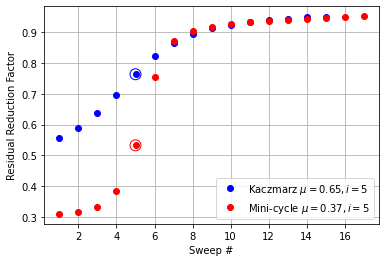

In [25]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, nu_pre=1, nu_post=1, nu_coarsest=nu_coarsest)

#### Observations
* The first cycle increases the residual! Unless enough relaxations (4) are performed at the finest level.
* Convergence is faster than relaxation ($0.4$ vs. $0.6$) until the slowdown.
* The RER at the PODR is a lot smaller than in relaxation.

## Level 1->2 Coarsening

### Two-level Bootstrapping

In [27]:
num_examples = 5
max_levels = 2
num_bootstrap_steps = 1

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel1 = hm.hierarchy.multilevel.Multilevel.create(level)
_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((level.a.shape[0], num_examples))
factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, lambda x, b: level.relax(x, b), (level.a.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1, leeway_factor=leeway_factor)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# Start from random again. Level 0 doesn't exist here.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
x_log.append(x)

# Improve vectors with 1-level relaxation.
_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel1 = hm.setup.auto_setup.bootstap(
        x, multilevel1, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, neighborhood=neighborhood,
        repetitive=repetitive)
    x_log.append(x)
    r_log.append(multilevel1[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)
    
# Merge the 1-2 hierarchy into the 0-1 to create 0-1-2.
multilevel.add(multilevel1[1])

INFO     Relax at level 0 size 48
INFO     [1.    0.392 0.447 0.503 0.551 0.59  0.622 0.651 0.675 0.697 0.716 0.733 0.747 0.761 0.773 0.783 0.793 0.802 0.81  0.817 0.824]
INFO     Relax conv 0.92 shrinkage 0.50 PODR RER 0.21 after 3 sweeps. Work 1.0 eff 0.50
INFO     Generating TVs with 3 sweeps
INFO     RER 0.225
INFO     bootstrap on grid size 48 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.939 asymptotic RQ 0.006 RER 0.050 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (24, 48) a 4 nc 2 cr 0.50 mean_energy_error 0.1299; mock cycle nu 4 conv 0.04 eff 0.67
INFO     Mock cycle conv factor [0.306 0.136 0.043]
INFO     P max error: fit 0.052 val 0.026 test 0.044; alpha mean 0.003
INFO     all  set size 5  P L2 error mean 0.03 max 0.06 A error mean 0.02 max 0.05
INFO     Level 1 size 24
INFO     RER 0.088154
INF

Note that we are now able to reduce the RER of the TVs consisently with bootstrap cycles at level 1.

### Level 2 Relaxation Shrinkage

Level size 24
INFO     Iter     |r|                         |x|         RER
INFO     0     8.945e-02                    4.439e-01    0.197
INFO     1     5.071e-02 (0.554) [0.554]    2.971e-01    0.172 (0.843)
INFO     2     2.696e-02 (0.551) [0.551]    2.488e-01    0.115 (0.662)
INFO     3     1.593e-02 (0.618) [0.574]    2.207e-01    0.077 (0.700)
INFO     4     1.249e-02 (0.790) [0.624]    2.022e-01    0.066 (0.870)
INFO     5     1.057e-02 (0.846) [0.664]    1.889e-01    0.060 (0.911)
INFO     6     9.150e-03 (0.861) [0.695]    1.781e-01    0.055 (0.919)
INFO     7     8.112e-03 (0.881) [0.721]    1.688e-01    0.051 (0.933)
INFO     8     7.310e-03 (0.895) [0.742]    1.608e-01    0.047 (0.943)
INFO     9     6.683e-03 (0.909) [0.760]    1.536e-01    0.045 (0.954)
INFO     10    6.178e-03 (0.920) [0.775]    1.471e-01    0.043 (0.963)
INFO     11    5.757e-03 (0.929) [0.789]    1.412e-01    0.042 (0.969)
INFO     12    5.399e-03 (0.935) [0.800]    1.357e-01    0.041 (0.974)
INFO     

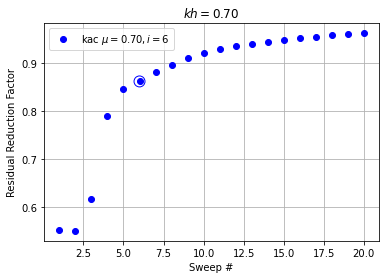

In [28]:
level = multilevel[2]
print("Level size {}".format(level.size))
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, 
    num_examples=5, leeway_factor=leeway_factor)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

INFO     Iter     |r|                         |x|         RER
INFO     0     1.191e+00                    4.468e-01    2.663
INFO     1     6.710e-01 (0.565) [0.565]    3.505e-01    1.921 (0.720)
INFO     2     4.032e-01 (0.603) [0.584]    3.047e-01    1.331 (0.694)
INFO     3     2.600e-01 (0.646) [0.604]    2.793e-01    0.936 (0.705)
INFO     4     1.821e-01 (0.702) [0.628]    2.630e-01    0.696 (0.745)
INFO     5     1.394e-01 (0.765) [0.654]    2.514e-01    0.557 (0.801)
INFO     6     1.158e-01 (0.829) [0.681]    2.422e-01    0.479 (0.861)
INFO     7     1.006e-01 (0.868) [0.705]    2.345e-01    0.430 (0.897)
INFO     8     9.000e-02 (0.894) [0.726]    2.279e-01    0.395 (0.920)
INFO     9     8.201e-02 (0.911) [0.745]    2.220e-01    0.370 (0.935)
INFO     10    7.563e-02 (0.922) [0.761]    2.167e-01    0.349 (0.944)
INFO     11    7.038e-02 (0.930) [0.775]    2.120e-01    0.332 (0.951)
INFO     12    6.596e-02 (0.937) [0.787]    2.076e-01    0.317 (0.957)
INFO     13    6.221e-0

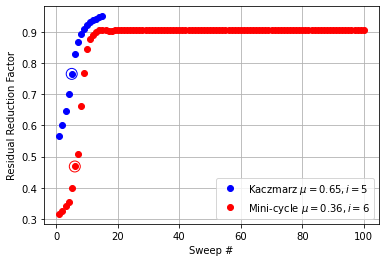

In [29]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, max_sweeps=100,
    nu_pre=1, nu_post=1, nu_coarsest=3)

* Level 2 relaxation behaves weirdly: it slows down after exactly one sweep. One sweep is fast, then the residual reduction goes up, then down, then slowly back up again.
* The Level 1-2 min-cycle is not more efficient.

### Operators

#### Level 0

In [30]:
pd.DataFrame(multilevel[0].a[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00,0.00
3,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00
4,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00
5,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00
6,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00
7,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08
8,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01


#### Level 1

In [31]:
pd.DataFrame(multilevel[1].a[:12, :12].todense())

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.04,-0.23,0.08,-0.33,0.00,-0.01,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.23,-0.55,0.08,-0.23,0.00,-0.01,0.00,0.00,0.00,0.00,0.00,0.00
2,0.08,0.08,0.04,-0.23,0.08,-0.33,0.00,-0.01,0.00,0.00,0.00,0.00
3,-0.33,-0.23,-0.23,-0.55,0.08,-0.23,0.00,-0.01,0.00,0.00,0.00,0.00
4,0.00,0.00,0.08,0.08,0.04,-0.23,0.08,-0.33,0.00,-0.01,0.00,0.00
5,-0.01,-0.01,-0.33,-0.23,-0.23,-0.55,0.08,-0.23,0.00,-0.01,0.00,0.00
6,0.00,0.00,0.00,0.00,0.08,0.08,0.04,-0.23,0.08,-0.33,0.00,-0.01
7,0.00,0.00,-0.01,-0.01,-0.33,-0.23,-0.23,-0.55,0.08,-0.23,0.00,-0.01
8,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.08,0.04,-0.23,0.08,-0.33
9,0.00,0.00,0.00,0.00,-0.01,-0.01,-0.33,-0.23,-0.23,-0.55,0.08,-0.23


In [32]:
pd.DataFrame(multilevel[1].p[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-0.16,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.47,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.70,-0.17,0.01,-0.12,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.44,-0.31,0.01,0.22,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.10,-0.14,-0.16,0.56,0.00,0.00,0.00,0.00,0.00,0.00
5,0.07,0.07,-0.47,0.53,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,-0.70,-0.17,0.01,-0.12,0.00,0.00,0.00,0.00
7,0.00,0.00,-0.44,-0.31,0.01,0.22,0.00,0.00,0.00,0.00
8,0.00,0.00,-0.10,-0.14,-0.16,0.56,0.00,0.00,0.00,0.00
9,0.00,0.00,0.07,0.07,-0.47,0.53,0.00,0.00,0.00,0.00


#### Level 2

In [33]:
pd.DataFrame(multilevel[2].a[:12, :12].todense())

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.10,-0.00,-0.16,-0.07,0.04,-0.01,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.00,0.02,0.07,-0.08,0.02,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00
2,-0.16,0.07,0.10,-0.00,-0.16,-0.07,0.04,-0.01,0.00,0.00,0.00,0.00
3,-0.07,-0.08,-0.00,0.02,0.07,-0.08,0.02,0.00,-0.00,-0.00,0.00,0.00
4,0.04,0.02,-0.16,0.07,0.10,-0.00,-0.16,-0.07,0.04,-0.01,0.00,0.00
5,-0.01,0.00,-0.07,-0.08,-0.00,0.02,0.07,-0.08,0.02,0.00,-0.00,-0.00
6,0.00,-0.00,0.04,0.02,-0.16,0.07,0.10,-0.00,-0.16,-0.07,0.04,-0.01
7,0.00,-0.00,-0.01,0.00,-0.07,-0.08,-0.00,0.02,0.07,-0.08,0.02,0.00
8,0.00,0.00,0.00,-0.00,0.04,0.02,-0.16,0.07,0.10,-0.00,-0.16,-0.07
9,0.00,0.00,0.00,-0.00,-0.01,0.00,-0.07,-0.08,-0.00,0.02,0.07,-0.08


In [34]:
pd.DataFrame(multilevel[2].p[:12, :12].todense())

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.63,0.65,-0.26,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.38,-0.24,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.15,-0.72,-0.18,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.63,0.18,-0.12,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.16,0.05,0.63,0.65,-0.26,0.01,0.00,0.00,0.00,0.00,0.00,0.00
5,0.23,0.02,0.38,-0.24,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,-0.17,0.04,0.15,-0.72,-0.18,-0.01,0.00,0.00,0.00,0.00,0.00,0.00
7,0.08,-0.01,-0.63,0.18,-0.12,0.05,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,-0.16,0.05,0.63,0.65,-0.26,0.01,0.00,0.00,0.00,0.00
9,0.00,0.00,0.23,0.02,0.38,-0.24,0.06,0.00,0.00,0.00,0.00,0.00


## How Does the Coarse Variables Look Like?
Print rows of $R_L \cdot \dots \cdot R_1$ and columns of $P_1 \cdot \dots \cdot P_L$ (for $L$ levels of coarsening).

In [35]:
r1 = multilevel[1].r
p1 = multilevel[1].p

r2 = multilevel[2].r
p2 = multilevel[2].p

p = p1.dot(p2)
r = r2.dot(r1)

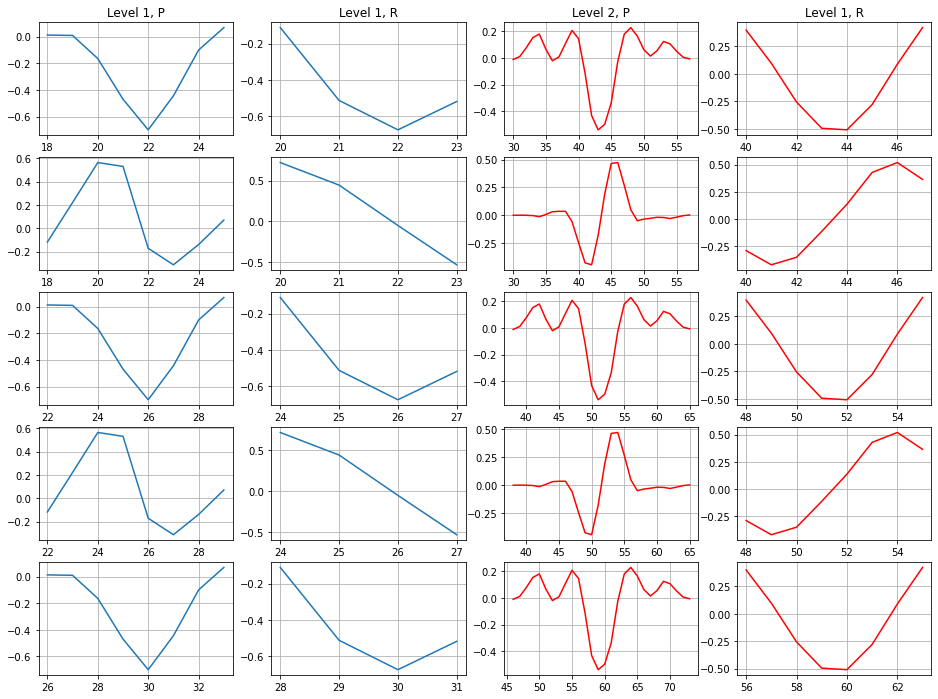

In [36]:
num_vars = 5
fig, axs = plt.subplots(num_vars, 4, figsize=(16, 12))
start_index = 10

col_titles = ("Level 1, P", "Level 1, R", "Level 2, P", "Level 1, R") 
for ax, col in zip(axs[0], col_titles):
    ax.set_title(col)
    
for i in range(num_vars):
    j = start_index + i
    
    ax = axs[i, 0]
    ax.plot(p1[:, j].nonzero()[0], p1[:, j].data)
    ax.grid(True)
    
    ax = axs[i, 1]
    ax.plot(r1[j].nonzero()[1], r1[j].data)
    ax.grid(True)
    
    ax = axs[i, 2]
    ax.plot(p[:, j].nonzero()[0], p[:, j].data, "r")
    ax.grid(True)
    
    ax = axs[i, 3]
    ax.plot(r[j].nonzero()[1], r[j].data, "r")
    ax.grid(True)

The coarse variables ($R$) look like wavelets. The interpolations ($P$) look like a sync, all makes sense.

## Eigenpairs of the Different Level Operators

In [41]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:13])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [-0.027 -0.027  0.062  0.062 -0.124 -0.124  0.143  0.143  0.216  0.216 -0.23  -0.23   0.28 ]
1 lam [-0.027 -0.027  0.062  0.062 -0.123 -0.126  0.141  0.141  0.208  0.208 -0.228 -0.228  0.263]
2 lam [-0.027 -0.027  0.053  0.053  0.063  0.063 -0.122 -0.128 -0.128 -0.136  0.155  0.155  0.164]


Looks like the smallest four eigenvalues are well approximated at all levels, to about $10\%$ error.

In [42]:
np.abs(laml[1][:10] - laml[0][:10]) / np.abs(laml[0][:10]), np.abs(laml[2][:10] - laml[0][:10]) / np.abs(laml[0][:10])

(array([0.002, 0.002, 0.003, 0.003, 0.013, 0.014, 0.015, 0.015, 0.035, 0.035]),
 array([0.017, 0.017, 0.155, 0.155, 1.51 , 1.51 , 1.851, 1.89 , 1.591, 1.629]))

### What Level 1 eigenvectors comprise the level 2 AZM?
We calculate $(v^2_i)^T (R_2 v^1)$, which gives us the spectral decomposition coefficients of the level 2 eigenvector $v^2_i$ in terms of the coarsened level 1 eigenvectors.

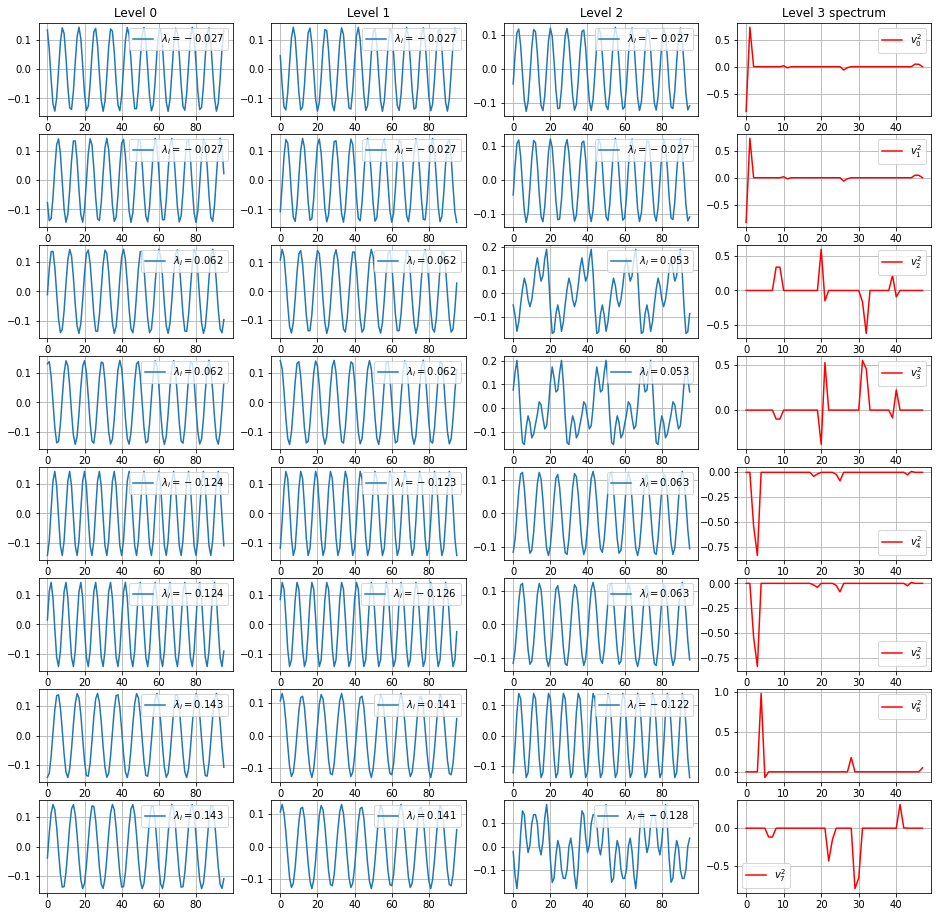

In [43]:
num_ev = 8
fig, axs = plt.subplots(num_ev, num_levels + 1, figsize=(16, 16))

for col, ax in enumerate(axs[0][:-1]):
    ax.set_title("Level {}".format(col))
axs[0, -1].set_title("Level {} spectrum".format(num_levels))

for i in range(num_ev):
    for l in range(num_levels):
        ax = axs[i, l]
        ax.plot(np.real(vl_finest[l][:, i]), label="$\lambda_i = {:.3f}$".format(laml[l][i]))
        ax.legend(loc="upper right")
        ax.grid(True);
        
composition = (r2.dot(vl[1])).transpose().dot(vl[2])
for i in range(num_ev):
    ax = axs[i, num_levels]
    ax.plot(np.real(composition[:, i]), "r", label = "$v^2_{}$".format(i))
    ax.grid(True)
    ax.legend();

Each level $2$ eigenvecttor corresponds to one level $1$ eigenvector (we don't see the noise introduced by test vectors that vary across the domain here).

In [46]:
## Level 2 -> 3 Coarsening
num_examples = 8
max_levels = 2
num_bootstrap_steps = 1

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel2 = hm.hierarchy.multilevel.Multilevel.create(level)
_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((level.a.shape[0], num_examples))
factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, lambda x, b: level.relax(x, b), (level.a.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1, leeway_factor=leeway_factor)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# Start from random again. Level 0 doesn't exist here.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
x_log.append(x)

# Improve vectors with 1-level relaxation.
_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel2 = hm.setup.auto_setup.bootstap(
        x, multilevel2, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, neighborhood=neighborhood,
        repetitive=repetitive)
    x_log.append(x)
    r_log.append(multilevel2[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)
    
# Merge the 1-2 hierarchy into the 0-1 to create 0-1-2.
multilevel.add(multilevel2[1])

INFO     Relax at level 0 size 24
INFO     [1.    0.423 0.487 0.559 0.612 0.657 0.69  0.715 0.736 0.752 0.766 0.778 0.788 0.798 0.806 0.813 0.82  0.827 0.833 0.838 0.843]
INFO     Relax conv 0.91 shrinkage 0.49 PODR RER 0.10 after 2 sweeps. Work 1.0 eff 0.49
INFO     Generating TVs with 2 sweeps
INFO     RER 0.118
INFO     bootstrap on grid size 24 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.885 asymptotic RQ -0.028 RER 0.032 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (16, 24) a 6 nc 4 cr 0.67 mean_energy_error 0.2464; mock cycle nu 2 conv 0.19 eff 0.76
INFO     Mock cycle conv factor [0.211 0.171 0.145]
INFO     P max error: fit 0.078 val 0.203 test 0.170; alpha mean 0.023
INFO     all  set size 8  P L2 error mean 0.08 max 0.11 A error mean 0.02 max 0.03
INFO     Level 1 size 16
INFO     RER 0.053217
IN

### Level 3 Relaxation Shrinkage

Level size 16
INFO     Iter     |r|                         |x|         RER
INFO     0     2.709e-02                    4.461e-01    0.061
INFO     1     1.135e-02 (0.421) [0.421]    3.119e-01    0.037 (0.612)
INFO     2     6.586e-03 (0.586) [0.499]    2.556e-01    0.026 (0.715)
INFO     3     4.819e-03 (0.733) [0.570]    2.231e-01    0.022 (0.844)
INFO     4     4.062e-03 (0.848) [0.628]    1.998e-01    0.021 (0.951)
INFO     5     3.489e-03 (0.861) [0.668]    1.806e-01    0.020 (0.957)
INFO     6     3.009e-03 (0.864) [0.696]    1.645e-01    0.019 (0.954)
INFO     7     2.613e-03 (0.870) [0.718]    1.508e-01    0.018 (0.954)
INFO     8     2.287e-03 (0.877) [0.736]    1.391e-01    0.017 (0.956)
INFO     9     2.017e-03 (0.883) [0.750]    1.291e-01    0.016 (0.956)
INFO     10    1.791e-03 (0.888) [0.763]    1.203e-01    0.016 (0.957)
INFO     11    1.603e-03 (0.893) [0.773]    1.126e-01    0.015 (0.957)
INFO     12    1.445e-03 (0.899) [0.783]    1.058e-01    0.014 (0.959)
INFO     

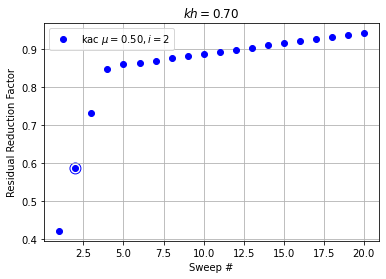

In [48]:
level = multilevel[3]
print("Level size {}".format(level.size))
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, 
    num_examples=5, leeway_factor=leeway_factor)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

On this level, relaxation converges quickly, so we can stop coarsening.

# Test Multilevel Cycle Convergence

### Solving $A x = 0$ (Periodic Fixed-Size Domain Problem)
That is, solving on a periodic fixed domain. Starting from random. Even solving exactly on the coarsest level works here.

In [50]:
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, num_levels=3, debug=True).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(multilevel.finest_level.operator, two_level_cycle, np.random.random((multilevel.finest_level.size, )), 8, print_frequency=1)

INFO         0 |r| 8.706e+00 RER 1.59847
INFO     --------------------------------------------------------------------------------
INFO     Level    Operation          |R|           RER       
INFO     0        initial            8.8858e-01    1.5985e+00
INFO     0        relax 1            5.2751e-01    1.0636e+00
INFO     1        initial            3.6493e-01    5.7069e-01
INFO     1        relax 1            3.2349e-01    9.3469e-01
INFO     2        initial            5.6642e-02    2.5555e-01
INFO     2        relax 10           1.0535e-02    3.1109e-02
INFO     2        coarsest           1.0535e-02    3.1109e-02
INFO     1        correction         3.3630e-01    8.4835e-01
INFO     1        relax 1            9.5941e-02    2.9285e-01
INFO     0        correction         5.1117e-01    2.0401e+00
INFO     0        relax 1            3.2431e-01    1.5848e+00
INFO         1 |r| 3.178e+00 (0.36497) RER 1.58480 (0.99145) 2.005
INFO     -------------------------------------------------

In [52]:
for nu in range(1, 5):
    two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 1).run(x)
    _, conv_factor = hm.solve.run.run_iterative_method(multilevel.finest_level.operator, two_level_cycle, np.random.random((multilevel.finest_level.size, )), 20)
    print("V({}, {}) conv factor {:.3f}".format(nu, 1, conv_factor))

V(1, 1) conv factor 1.281
V(2, 1) conv factor 0.659
V(3, 1) conv factor 0.347
V(4, 1) conv factor 0.219


### Solving $Ax = b$
Works the same way as for $Ax = 0$.

In [53]:
# Random RHS.
b = np.random.random((a0.shape[0], ))

two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, rhs=b).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(lambda x: b - multilevel.finest_level.operator(x), two_level_cycle, np.random.random((multilevel.finest_level.size, )), 20, print_frequency=1)

INFO         0 |r| 8.087e+00 RER 1.54128
INFO         1 |r| 3.543e+00 (0.43810) RER 0.20210 (0.13113) 17.530
INFO         2 |r| 1.548e+00 (0.43704) RER 0.09317 (0.46103) 16.618
INFO         3 |r| 1.026e+00 (0.66269) RER 0.06275 (0.67352) 16.351
INFO         4 |r| 1.428e+00 (1.39141) RER 0.08785 (1.39991) 16.251
INFO         5 |r| 1.517e+00 (1.06225) RER 0.09168 (1.04355) 16.543
INFO         6 |r| 1.715e+00 (1.13053) RER 0.10354 (1.12938) 16.560
INFO         7 |r| 2.562e+00 (1.49408) RER 0.15261 (1.47395) 16.786
INFO         8 |r| 3.422e+00 (1.33597) RER 0.19400 (1.27124) 17.640
INFO         9 |r| 3.969e+00 (1.15985) RER 0.22449 (1.15716) 17.681
INFO        10 |r| 4.525e+00 (1.13998) RER 0.24158 (1.07614) 18.730
INFO        11 |r| 6.414e+00 (1.41755) RER 0.31148 (1.28932) 20.593
INFO        12 |r| 8.987e+00 (1.40109) RER 0.39666 (1.27348) 22.657
INFO        13 |r| 1.034e+01 (1.15036) RER 0.39336 (0.99168) 26.282
INFO        14 |r| 1.164e+01 (1.12618) RER 0.40515 (1.02997) 28.737
INFO   

### Solving $A x = \lambda x$
Work in progress.

In [54]:
# level = multilevel.finest_level
# lam = 0

# eigen_cycle = lambda x, lam: hm.setup_eigen.eigensolver.eigen_cycle(multilevel, 1.0, 1, 1, 100, debug=True).run((x, lam))
# # FMG start so (x, lambda) has a reasonable initial guess.
# #x = hm.setup_eigen.bootstrap_eigen.fmg(multilevel, num_cycles_finest=0)
# x = np.random.random((a0.shape[0], 1))
# x, lam, conv_factor = hm.solve.run.run_iterative_eigen_method(level.operator, eigen_cycle, x, lam, 20, print_frequency=1)

## Automating the Entire Setup Phase
Looks like the process is sensitive in two ways depending on the random seed (used to generate the initial TV at each level):
* We might not find a good coarsening whose mock cycle rate < $0.4$ (the maximum allowed).
* We might have too many interpolation points and not enough windows/test vectors. Especially if we coarsen by 6/4 at some point (that's because we do not yet truncate small $P$ weight).
* The ML cycle may strongly diverge because of a particular level.
* The domain size may not be divisible by the the aggregate size. $R$ can be periodic with an overlapping aggregate, but $P$ cannot be.

### A Happy Case

In [57]:
np.random.seed(0)

multilevel = hm.setup.auto_setup.setup(a0, repetitive=repetitive, leeway_factor=leeway_factor)
print ("#levels", len(multilevel.level))

# Solve Ax=0.
b = np.zeros((a0.shape[0], ))
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, rhs=b, num_levels=3).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(lambda x: b - multilevel[0].operator(x), two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

INFO     [1.    0.565 0.578 0.6   0.627 0.654 0.68  0.704 0.725 0.744 0.76  0.774 0.786 0.797 0.807 0.815 0.823 0.83  0.837 0.843 0.848]
INFO     level 0 size 96 relax conv 0.95 shrinkage 0.73 PODR RER 0.45 after 8 sweeps. Work 1.0 eff 0.73
INFO     ================================================================================
INFO     Coarsening level 0->1
INFO     Generating 2 TV with 8 sweeps
INFO     RER 0.389
INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.925 asymptotic RQ 0.015 RER 0.113 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.0398; mock cycle nu 2 conv 0.32 eff 0.75
INFO     Mock cycle conv factor [0.315 0.184 0.122]
INFO     P max error: fit 0.056 val 0.031 test 0.069; alpha mean 0.000
INFO     all  set size 2  P L

AttributeError: 'Multilevel' object has no attribute 'level'

### Case of Slow Solution Cycle

In [58]:
np.random.seed(2)

multilevel = hm.setup.auto_setup.setup(a0, repetitive=repetitive, leeway_factor=leeway_factor)
print ("#levels", len(multilevel.level))

# Solve Ax=0.
b = np.zeros((a0.shape[0], ))
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, rhs=b, num_levels=3).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(lambda x: b - multilevel.level[0].operator(x), two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

INFO     [1.    0.566 0.58  0.601 0.626 0.654 0.681 0.706 0.727 0.746 0.762 0.776 0.788 0.799 0.809 0.818 0.826 0.833 0.839 0.845 0.851]
INFO     level 0 size 96 relax conv 0.96 shrinkage 0.73 PODR RER 0.41 after 8 sweeps. Work 1.0 eff 0.73
INFO     ================================================================================
INFO     Coarsening level 0->1
INFO     Generating 2 TV with 8 sweeps
INFO     RER 0.402
INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.920 asymptotic RQ -0.052 RER 0.150 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.0832; mock cycle nu 3 conv 0.18 eff 0.75
INFO     Mock cycle conv factor [0.318 0.186 0.126]
INFO     P max error: fit 0.043 val 0.042 test 0.119; alpha mean 0.005
INFO     all  set size 2  P 

Exception: Could not find a coarsening whose mock cycle is below 0.40

### Dependence on $kh$
$kh = 0.5$ is supposedly the hardest case. Here it works with the same efficiency as $kh = 0.7$.

In [59]:
n = 96
kh = 0.5
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

np.random.seed(0)
multilevel = hm.setup.auto_setup.setup(a, repetitive=repetitive, leeway_factor=leeway_factor,
                                      max_levels=3)
print ("#levels", len(multilevel.level))

for nu in range(1, 5):
    two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 1).run(x)
    _, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, np.random.random((a0.shape[0], )), 20)
    print("V({}, {}) conv factor {:.3f}".format(nu, 1, conv_factor))

INFO     [1.    0.554 0.567 0.589 0.614 0.64  0.666 0.69  0.711 0.73  0.746 0.761 0.774 0.786 0.796 0.806 0.815 0.823 0.83  0.836 0.843]
INFO     level 0 size 96 relax conv 0.96 shrinkage 0.71 PODR RER 0.39 after 8 sweeps. Work 1.0 eff 0.71
INFO     ================================================================================
INFO     Coarsening level 0->1
INFO     Generating 2 TV with 8 sweeps
INFO     RER 0.361
INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.947 asymptotic RQ 0.188 RER 0.229 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 2 nc 1 cr 0.50 mean_energy_error 0.2615; mock cycle nu 2 conv 0.26 eff 0.71
INFO     Mock cycle conv factor [0.276 0.222 0.229]
INFO     P max error: fit 0.031 val 0.028 test 0.098; alpha mean 0.000
INFO     all  set size 2  P L

AttributeError: 'Multilevel' object has no attribute 'level'

### Dependence on Problem Size
Convergence degrades with increasing size at the moment. Sometimes the cycle completely diverges.

In [ ]:
kh = 0.5
for n in 96 * 2 ** np.arange(4):
    a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

    np.random.seed(2)
    multilevel = hm.setup.auto_setup.setup(a, repetitive=repetitive, leeway_factor=leeway_factor,
                                          max_levels=3)
    print("n", n, "#levels", len(multilevel.level))

    for nu in range(1, 5):
        two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 1).run(x)
        _, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, np.random.random((multilevel.level[0].size, )), 20)
        print("V({}, {}) conv factor {:.3f}".format(nu, 1, conv_factor))

## Level 1 Cycle Convergence Test

In [ ]:
m1 = multilevel
print(len(multilevel))
m1.level = multilevel.sub_hierachy(1)
sz = m1.level[0].size

np.random.seed(0)
x0 = np.random.random((sz, ))
b = m1.level.operator(x0)

two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(m1, 1.0, 1, 1, rhs=b, num_levels=2, debug=True).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(m1.level[0].operator, two_level_cycle, np.random.random((sz, )), 8, print_frequency=1)
plt.plot(x)

In [ ]:
len(multilevel.level)

In [ ]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel.level):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:13])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel.level)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel.level[k].p.dot(v)
    vl_finest.append(v)

In [ ]:
len(multilevel.level)

In [ ]:
num_ev = 8
fig, axs = plt.subplots(num_ev, num_levels + 1, figsize=(16, 16))

for col, ax in enumerate(axs[0][:-1]):
    ax.set_title("Level {}".format(col))
axs[0, -1].set_title("Level {} spectrum".format(num_levels))

for i in range(num_ev):
    for l in range(num_levels):
        ax = axs[i, l]
        ax.plot(np.real(vl_finest[l][:, i]), label="$\lambda_i = {:.3f}$".format(laml[l][i]))
        ax.legend(loc="upper right")
        ax.grid(True);
        
composition = (r2.dot(vl[1])).transpose().dot(vl[2])
for i in range(num_ev):
    ax = axs[i, num_levels]
    ax.plot(np.real(composition[:, i]), "r", label = "$v^2_{}$".format(i))
    ax.grid(True)
    ax.legend();

In [ ]:
pd.DataFrame(multilevel.level[2].p.todense())

In [ ]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, max_sweeps=20,
    nu_pre=1, nu_post=1, num_levels=2, nu_coarsest=3, slow_conv_factor=0.95)

In [ ]:
m1.level[1].size